### Inference Analysis



# Proposal of baseline scores: 

Option 1: 
I propose giving an average on the three images (n_predictions =3) as the baseline dice score as option one
so, you make the average of the scores of n_predictions = 3 or try finding out with other numbers
##found in last cell in effect of support set sizes


Option 2: 
Do the same but adding ensembling. 
##found at the end of this file


In [2]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import itertools
import math
import einops as E
import pathlib
import os
import subprocess
from dataclasses import dataclass
from typing import Literal, Optional, Tuple
from torch.utils.data import Dataset
import PIL
from PIL import Image
import matplotlib.pyplot as plt


In [3]:
# Define folders with double backslashes
#Input Image path in support set
support_input_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\Training\\train_input_png"

#first mask in training
support_output_nonpap_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\Training\\train_nonpapoutput_png"

#second mask in training
support_output_pap_folder = 'C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\Training\\train_pap_png'

#Input Image path in test set
test_input_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\testinput"

#first mark in test
test_output_nonpap_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\test_nonpap_output_png"

#second mask in test
test_output_pap_folder =  "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\test_pap_output_png"

In [4]:


current_directory = os.getcwd()
print("Current directory:", current_directory)

# Get the current directory
current_directory = os.getcwd()

# List the contents of the current directory
contents = os.listdir(current_directory)

# Print the contents
print("Contents of the current directory:")
for item in contents:
    print(item)


Current directory: C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\universeg
Contents of the current directory:
.ipynb_checkpoints
inference_analysis.ipynb
model.py
nn
training.py
universeg_scratch.py
validation.py
__init__.py
__pycache__


In [5]:
# !git clone https://github.com/JJGO/UniverSeg
# !python -m pip install -r ./UniverSeg/requirements.txt
# # Add package directory to path
#!pip install torch


import torch
from model import universeg

# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'



# Instantiate the model and move it to the device
model = universeg(pretrained=True)
model.to(device)



UniverSeg(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (enc_blocks): ModuleList(
    (0): CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
      (support): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (1-3): 3 x CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_si

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Move the model to the GPU
    device = torch.device('cuda')
    model.to(device)
    print("Model moved to CUDA (GPU)")
else:
    print("CUDA is not available. Model remains on CPU.")


CUDA is not available. Model remains on CPU.


In [7]:
torch.cuda.get_arch_list()

[]

In [8]:
# import pathlib
# import subprocess
# from dataclasses import dataclass
# from typing import Literal, Optional, Tuple
# 
# import numpy as np
# import PIL
# import torch
# from torch.utils.data import Dataset
# 
# 
# def process_img(path: pathlib.Path, size: Tuple[int, int]):
#     img = PIL.Image.open(path)
#     img = img.resize(size, resample=PIL.Image.BILINEAR)
#     img = img.convert("L")
#     img = np.array(img)
#     img = img.astype(np.float32)
#     return img
# 
# 
# def process_seg(path: pathlib.Path, size: Tuple[int, int]):
#     seg = PIL.Image.open(path)
#     seg = seg.resize(size, resample=PIL.Image.NEAREST)
#     seg = np.array(seg)
#     seg = np.stack([seg == 0, seg == 128, seg == 255])
#     seg = seg.astype(np.float32)
#     return seg
# 
# 
# def load_folder(path: pathlib.Path, size: Tuple[int, int] = (128, 128)):
#     data = []
#     for file in sorted(path.glob("*.png")):
#         img = process_img(file, size=size)
#         seg_file = file.with_suffix(".png")
#         seg = process_seg(seg_file, size=size)
#         data.append((img / 255.0, seg))
#     return data
# 
# # 
# # def require_download_wbc():
# #     dest_folder = pathlib.Path("/tmp/universeg_wbc/")
# # 
# #     if not dest_folder.exists():
# #         repo_url = "https://github.com/zxaoyou/segmentation_WBC.git"
# #         subprocess.run(
# #             ["git", "clone", repo_url, str(dest_folder),],
# #             stderr=subprocess.DEVNULL,
# #             check=True,
# #         )
# # 
# #     return dest_folder
# 
# def load_custom_dataset(input_folder: str, output_folder: str, size: Tuple[int, int] = (256, 256)):
#     data = []
#     input_path = pathlib.Path(input_folder)
#     output_path = pathlib.Path(output_folder)
#     
#     for file in sorted(input_path.glob("*.png")):
#         img = process_img(file, size=size)
#         seg_file = output_path / (file.stem + "_nonpapoutput.png")
#         seg = process_seg(seg_file, size=size)
#         data.append((img / 255.0, seg))
#     
#     return data
# 
# 
# @dataclass
# class WBCDataset(Dataset):
#     dataset: Literal["JTSC", "CV"]
#     split: Literal["support", "test"]
#     label: Optional[Literal["nucleus", "cytoplasm", "background"]] = None
#     support_frac: float = 0.7
# 
#     def __post_init__(self):
#         root = require_download_wbc()
#         path = root / {"JTSC": "Dataset 1", "CV": "Dataset 2"}[self.dataset]
#         T = torch.from_numpy
#         self._data = [(T(x)[None], T(y)) for x, y in load_folder(path)]
#         if self.label is not None:
#             self._ilabel = {"cytoplasm": 1, "nucleus": 2, "background": 0}[self.label]
#         self._idxs = self._split_indexes()
# 
#     def _split_indexes(self):
#         rng = np.random.default_rng(42)
#         N = len(self._data)
#         p = rng.permutation(N)
#         i = int(np.floor(self.support_frac * N))
#         return {"support": p[:i], "test": p[i:]}[self.split]
# 
#     def __len__(self):
#         return len(self._idxs)
# 
#     def __getitem__(self, idx):
#         img, seg = self._data[self._idxs[idx]]
#         if self.label is not None:
#             seg = seg[self._ilabel][None]
#         return img, seg


### Inference using papillary masks

In [9]:
# def process_img(path: pathlib.Path, size: Tuple[int, int]):
#     img = PIL.Image.open(path)
#     img = img.resize(size, resample=PIL.Image.BILINEAR)
#     img = img.convert("L") #makes the image grayscale
#     img = np.array(img)
#     img = img.astype(np.float32)
#     return img
# 
# def process_seg(path: pathlib.Path, size: Tuple[int, int]):
#     seg = PIL.Image.open(path)
#     seg = seg.resize(size, resample=PIL.Image.NEAREST)
#     seg = np.array(seg)
#     seg = np.expand_dims(seg == 255, axis=0)
#     seg = seg.astype(np.float32)
#     return seg
# 
# 
# 
# def load_custom_dataset(input_folder: str, output_folder: str, size: Tuple[int, int] = (128, 128)):
#     data = []
#     input_path = pathlib.Path(input_folder)
#     output_path = pathlib.Path(output_folder)
# 
#     for file in sorted(input_path.glob("*.png")):
#         img = process_img(file, size=size)
#         count = 1
#         seg_filename = f"Segment{count:05}.png"
#         seg_file = output_path / seg_filename
#         # seg = process_seg(seg_file, size=size)
#         # #data.append((img / 256.0, seg))
#         # 
#         if seg_file.exists():  # Check if the segmentation mask file exists
#             seg = process_seg(seg_file, size=size)
#             data.append((img / 256.0, seg))
#         else:
#             print(f"Segmentation mask file '{seg_filename}' not found. Skipping.")
# 
#     #return data
#     return data
# 
# @dataclass
# class CustomDataset(Dataset):
#     input_folder: str
#     output_folder: str
#     size: Tuple[int, int] = (128, 128)
#     
#     
#     # def __post_init__(self):
#     #     # self._data = load_custom_dataset(self.input_folder, self.output_folder, size=self.size)
#     #     self._data = load_custom_dataset(self.input_folder, self.output_folder, size = self.size)
#     #     
#     #     T = torch.from_numpy
#     #     self._data = [(T(x)[None], T(y)) for x, y in load_folder(path)]
#     #     self._idxs = list(range(len(self._data)))
#     def __post_init__(self):
#         self._data = load_custom_dataset(self.input_folder, self.output_folder, size=self.size)
#         
#         T = torch.from_numpy
#         self._data = [(T(x)[None], T(y)) for x, y in self._data]
#         self._idxs = list(range(len(self._data)))
# 
#         
#     def __len__(self):
#         return len(self._idxs)
# 
#     def __getitem__(self, idx):
#         img, seg = self._data[self._idxs[idx]]
#         return img, seg


In [10]:
# support_dataset = CustomDataset(support_input_folder, support_output_folder)
# test_dataset = CustomDataset(test_input_folder, test_output_folder)


In [11]:
def process_image(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process input image."""
    img = PIL.Image.open(path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")  # Convert image to grayscale
    img = np.array(img, dtype=np.float32)
    return img 

def process_segmentation(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = np.array(seg)
    seg = np.expand_dims(seg == 255, axis=0)
    return seg.astype(np.float32)

def load_dataset(input_folder: str, label: str = None, size: Tuple[int, int] = (128, 128)):
    """Load dataset from folder with optional custom segmentation mask."""
    data = []
    input_path = pathlib.Path(input_folder)
    label_path = pathlib.Path(label) if label else None

    for file in sorted(input_path.glob("*.png")):
        img = process_image(file, size=size)
        count = 1

        # If label folder is provided, use the segmentation mask, otherwise, use None
        seg = None
        if label_path:
            seg_file = label_path / f"Segment{count:05}.png"
            if seg_file.exists():
                seg = process_segmentation(seg_file, size=size)
            else:
                print(f"Segmentation mask file '{seg_file}' not found. Skipping.")

        data.append((img / 256.0, seg))
        count += 1

    return data


class VentricleDataset(Dataset):
    def __init__(self, input_folder: str, label: str = None, size: Tuple[int, int] = (128, 128)):
        self.data = load_dataset(input_folder, label, size=size)
        T = torch.from_numpy
        self.data = [(T(x)[None], T(y)) for x, y in self.data]
        self.idxs = list(range(len(self.data)))

    def __len__(self):
        return len(self.data)

    # def __getitem__(self, idx):
    #     input_img, seg = self.data[idx]
    #     return torch.tensor(input_img), torch.tensor(seg)
    def __getitem__(self, idx):
        input_img, seg = self.data[self.idxs[idx]]
        return input_img, seg
# Create datasets
# support_dataset_pap = VentricleDataset(support_input_folder, label=support_output_pap_folder)
# support_dataset_nonpap = VentricleDataset(support_input_folder, label=support_output_nonpap_folder)
# 
# test_dataset_pap = VentricleDataset(test_input_folder, label=test_output_pap_folder)
# test_dataset_nonpap = VentricleDataset(test_input_folder, label=test_output_nonpap_folder)


In [12]:
# from typing import Optional, Tuple, Literal
# from pathlib import Path
# import torch
# from torch.utils.data import Dataset
# import itertools
# 
# def load_dataset(input_folder: str, papillary_folder: str = None, non_papillary_folder: str = None, label: Optional[str] = None, size: Tuple[int, int] = (128, 128)):
#     """Load dataset from folder with optional custom segmentation masks."""
#     data = []
#     input_path = Path(input_folder)
#     papillary_path = Path(papillary_folder) if papillary_folder else None
#     non_papillary_path = Path(non_papillary_folder) if non_papillary_folder else None
# 
#     for file in sorted(input_path.glob("*.png")):
#         img = process_image(file, size=size)
#         count = 1
# 
#         # If label is None, load both papillary and non-papillary segmentation masks
#         if label is None:
#             papillary_seg = None
#             non_papillary_seg = None
# 
#             # Load papillary segmentation mask if available
#             if papillary_path:
#                 papillary_seg_file = papillary_path / f"Segment{count:05}.png"
#                 if papillary_seg_file.exists():
#                     papillary_seg = process_segmentation(papillary_seg_file, size=size)
#                 else:
#                     print(f"Papillary segmentation mask file '{papillary_seg_file}' not found. Skipping.")
#             
#             # Load non-papillary segmentation mask if available
#             if non_papillary_path:
#                 non_papillary_seg_file = non_papillary_path / f"Segment{count:05}.png"
#                 if non_papillary_seg_file.exists():
#                     non_papillary_seg = process_segmentation(non_papillary_seg_file, size=size)
#                 else:
#                     print(f"Non-papillary segmentation mask file '{non_papillary_seg_file}' not found. Skipping.")
#             
#             # Append both segmentation masks to data
#             data.append((img / 256.0, papillary_seg, non_papillary_seg))
# 
#         # If a specific label is provided, load the corresponding segmentation mask
#         elif label == 'papillary':
#             if papillary_path:
#                 papillary_seg_file = papillary_path / f"Segment{count:05}.png"
#                 if papillary_seg_file.exists():
#                     papillary_seg = process_segmentation(papillary_seg_file, size=size)
#                 else:
#                     print(f"Papillary segmentation mask file '{papillary_seg_file}' not found. Skipping.")
#             else:
#                 print("Papillary folder not provided. Skipping.")
#             data.append((img / 256.0, papillary_seg))
# 
#         elif label == 'non_papillary':
#             if non_papillary_path:
#                 non_papillary_seg_file = non_papillary_path / f"Segment{count:05}.png"
#                 if non_papillary_seg_file.exists():
#                     non_papillary_seg = process_segmentation(non_papillary_seg_file, size=size)
#                 else:
#                     print(f"Non-papillary segmentation mask file '{non_papillary_seg_file}' not found. Skipping.")
#             else:
#                 print("Non-papillary folder not provided. Skipping.")
#             data.append((img / 256.0, non_papillary_seg))
# 
#         else:
#             print("Invalid label specified. Skipping.")
# 
#     return data
# 
# 
# class VentricleDataset(Dataset):
#     def __init__(self, input_folder: str, label: Optional[Literal["papillary", "non_papillary"]] = None, size: Tuple[int, int] = (128, 128)):
#         self.data = load_dataset(input_folder, label, size=size)
#         self.label = label
#         T = torch.from_numpy
#         if label is not None:
#             self.data = [(T(x)[None], T(y)) for x, y, z in self.data]  # Modify here to handle both masks
#         else:
#             self.data = [(T(x)[None], T(y), T(z)) for x, y, z in self.data]
#         self.idxs = list(range(len(self.data)))
# 
#     def __len__(self):
#         return len(self.data)
# 
#     def __getitem__(self, idx):
#         if self.label is None:
#             input_img, papillary_seg, non_papillary_seg = self.data[self.idxs[idx]]
#             return input_img, papillary_seg, non_papillary_seg
#         else:
#             input_img, seg = self.data[self.idxs[idx]]
#             return input_img, seg
# 
# # Example usage
# 
# # Load the dataset with label=None to perform multi-label prediction
# d_support = VentricleDataset(support_input_folder, label=None)
# d_test = VentricleDataset(test_input_folder, label=None)
# 
# n_support = 64
# 
# # Get support images and labels
# support_images, support_papillary_labels, support_non_papillary_labels = zip(*itertools.islice(d_support, n_support))
# support_images = torch.stack(support_images).to(device)
# support_papillary_labels = torch.stack(support_papillary_labels).to(device)
# support_non_papillary_labels = torch.stack(support_non_papillary_labels).to(device)
# 
# # Consolidate the support labels (you can adjust the consolidation logic as needed)
# support_labels = torch.max(support_papillary_labels, support_non_papillary_labels)
# 
# # Perform similar steps for the test dataset if needed
# 
# # Now you can use support_images and support_labels for training
# # 


In [13]:
# import os
# import cv2
# import numpy as np
# import pandas as pd
# import scipy.io as sio
# import torch
# from torch.utils.data import Dataset
# from typing import Literal, Optional
# 
# class CustomDataset(Dataset):
#     def __init__(self, dataset: Literal["train", "test"]):
#         self.dataset = dataset
#         self.image_folder = None
#         self.mask_folder = None
#         self.df = None
#         if dataset == "train":
#             self.image_folder = "Training/train_input_png"
#             self.mask_folder = "Training/train_nonpapoutput_png"
#             self.df = pd.read_csv("Training_Output.csv")
#         elif dataset == "test":
#             self.image_folder = "testinput"
#             self.mask_folder = "test_nonpap_output_png"
#             self.df = pd.read_csv("Testing_Input.csv")
# 
#     def __len__(self):
#         return len(self.df)
# 
#     def __getitem__(self, idx):
#         img_path = os.path.join(self.image_folder, self.df.iloc[idx]['Processed_Image_File'])
#         mask_path = os.path.join(self.mask_folder, self.df.iloc[idx]['Training_Output_Mask'])
# 
#         # Load image
#         image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
#         image = np.expand_dims(image, axis=0)  # Add channel dimension
# 
#         # Load mask
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_AREA)
#         mask = np.expand_dims(mask, axis=0)  # Add channel dimension
# 
#         return torch.from_numpy(image), torch.from_numpy(mask)


### Inference on unseen task using Universeg

In [14]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None, figsize=(15, 15)):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

In [15]:
# n_support = 48
# support_loader = torch.utils.data.DataLoader(d_support, batch_size=n_support, shuffle=True)
# # print("Number of input files:", len(d_support.input_files))
# # print("Number of output files:", len(d_support.output_files))
# 
# for batch_idx, (support_images, support_labels) in enumerate(support_loader):
#     support_images = support_images.to(device)

In [16]:
#     support_labels = support_labels.to(device)

d_support = VentricleDataset(support_input_folder, label=support_output_nonpap_folder)
d_test = VentricleDataset(test_input_folder, label=test_output_nonpap_folder)

n_support = 48

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
 
# # Use torch.stack() to stack tensors
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)


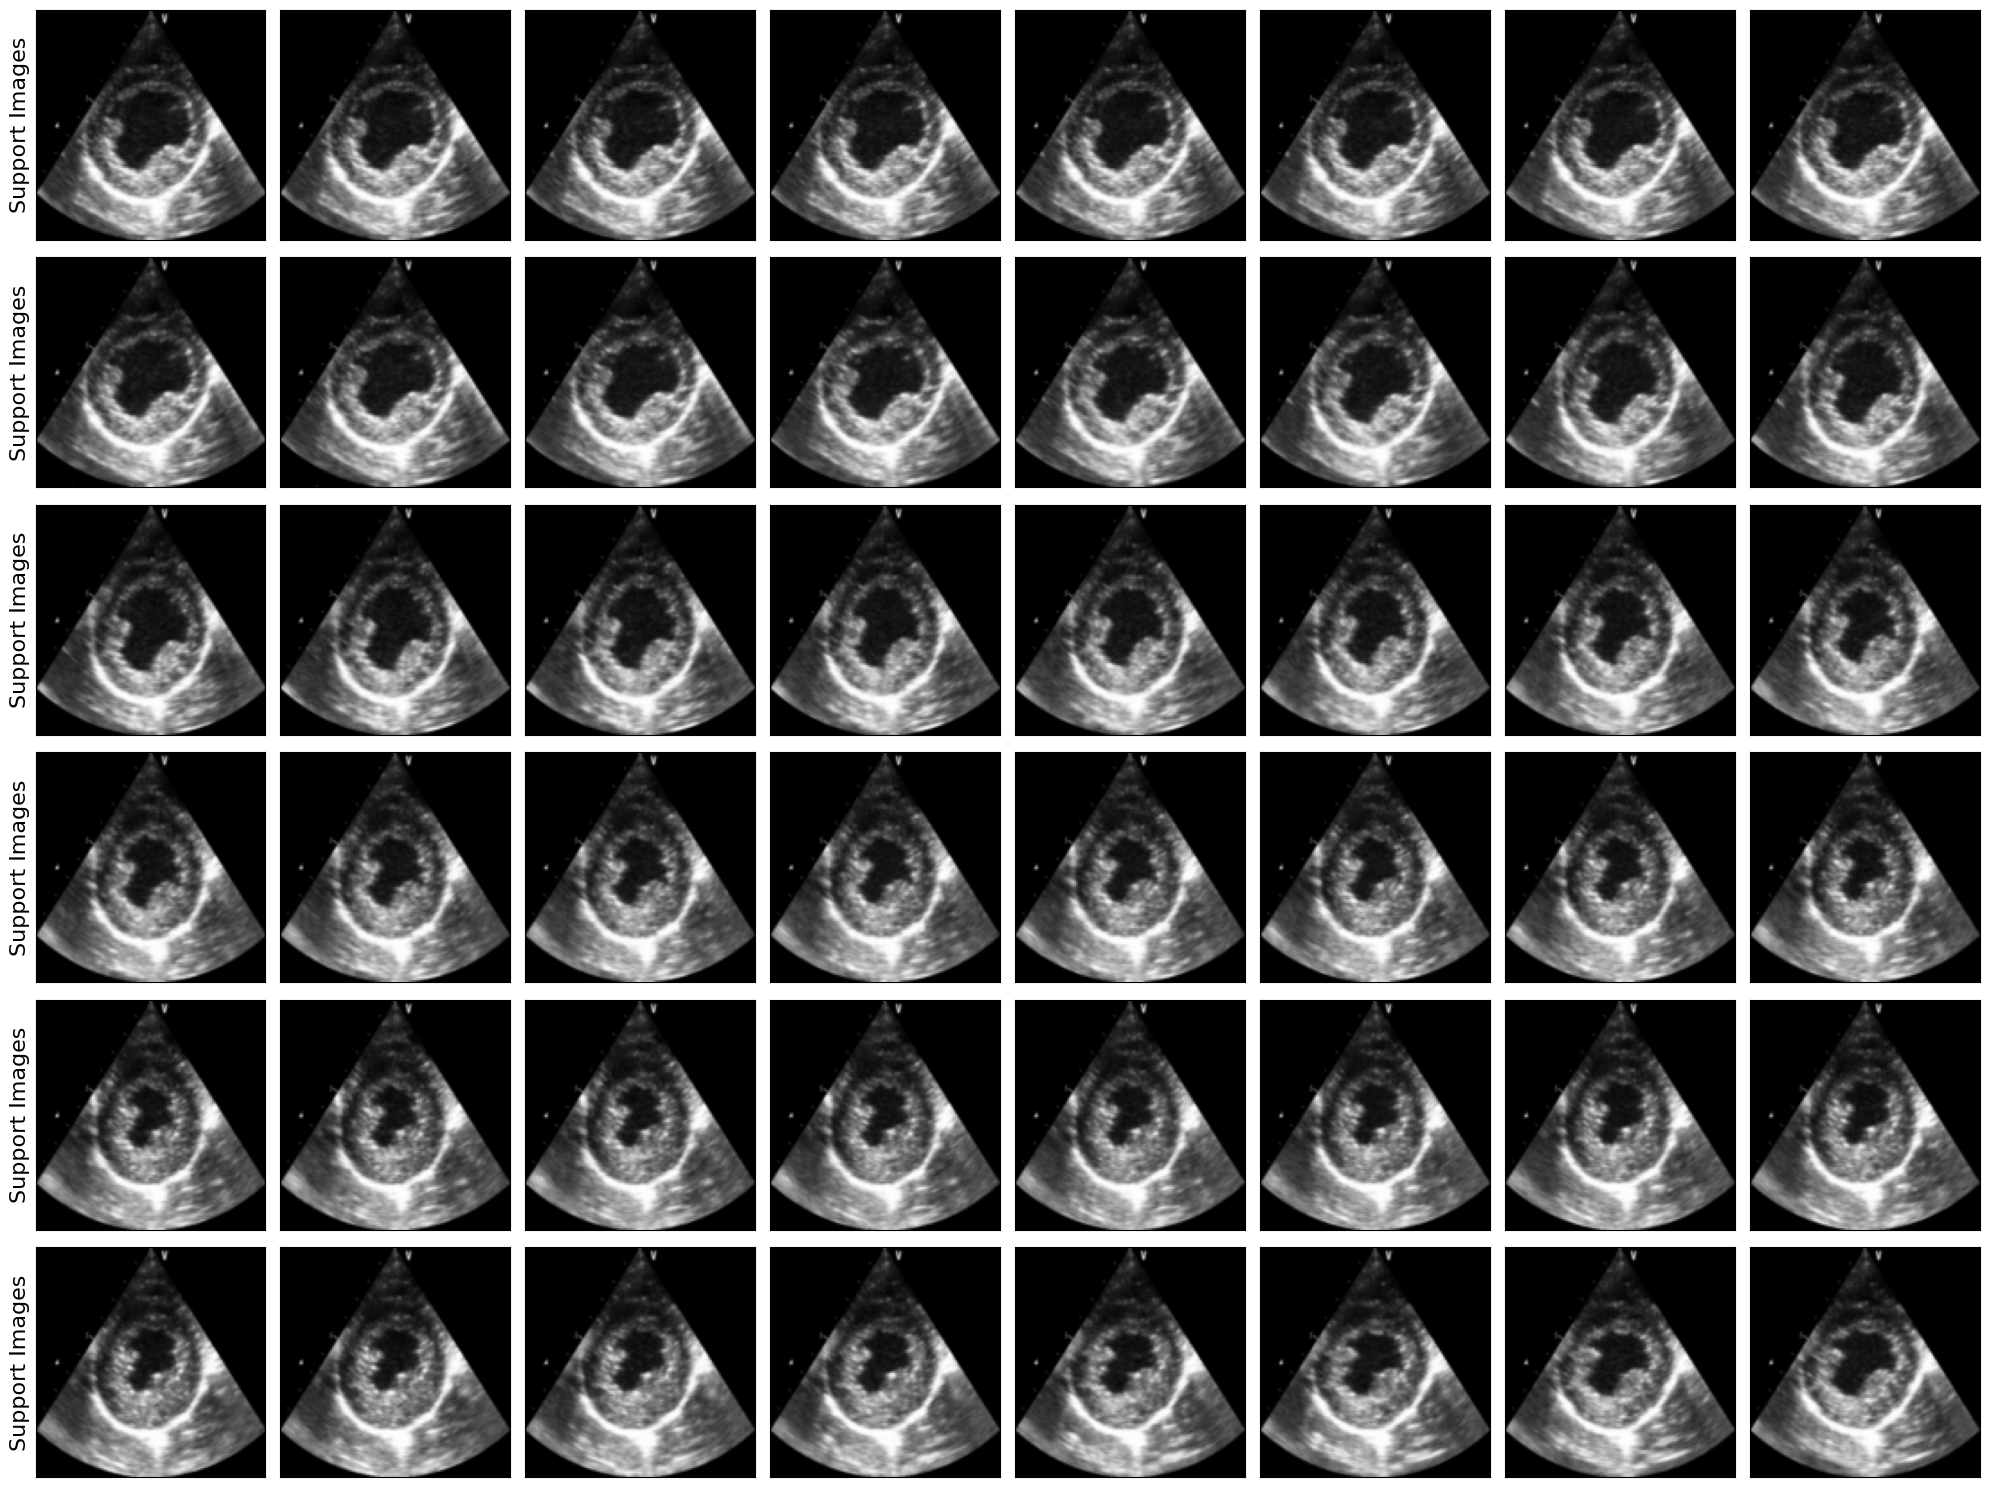

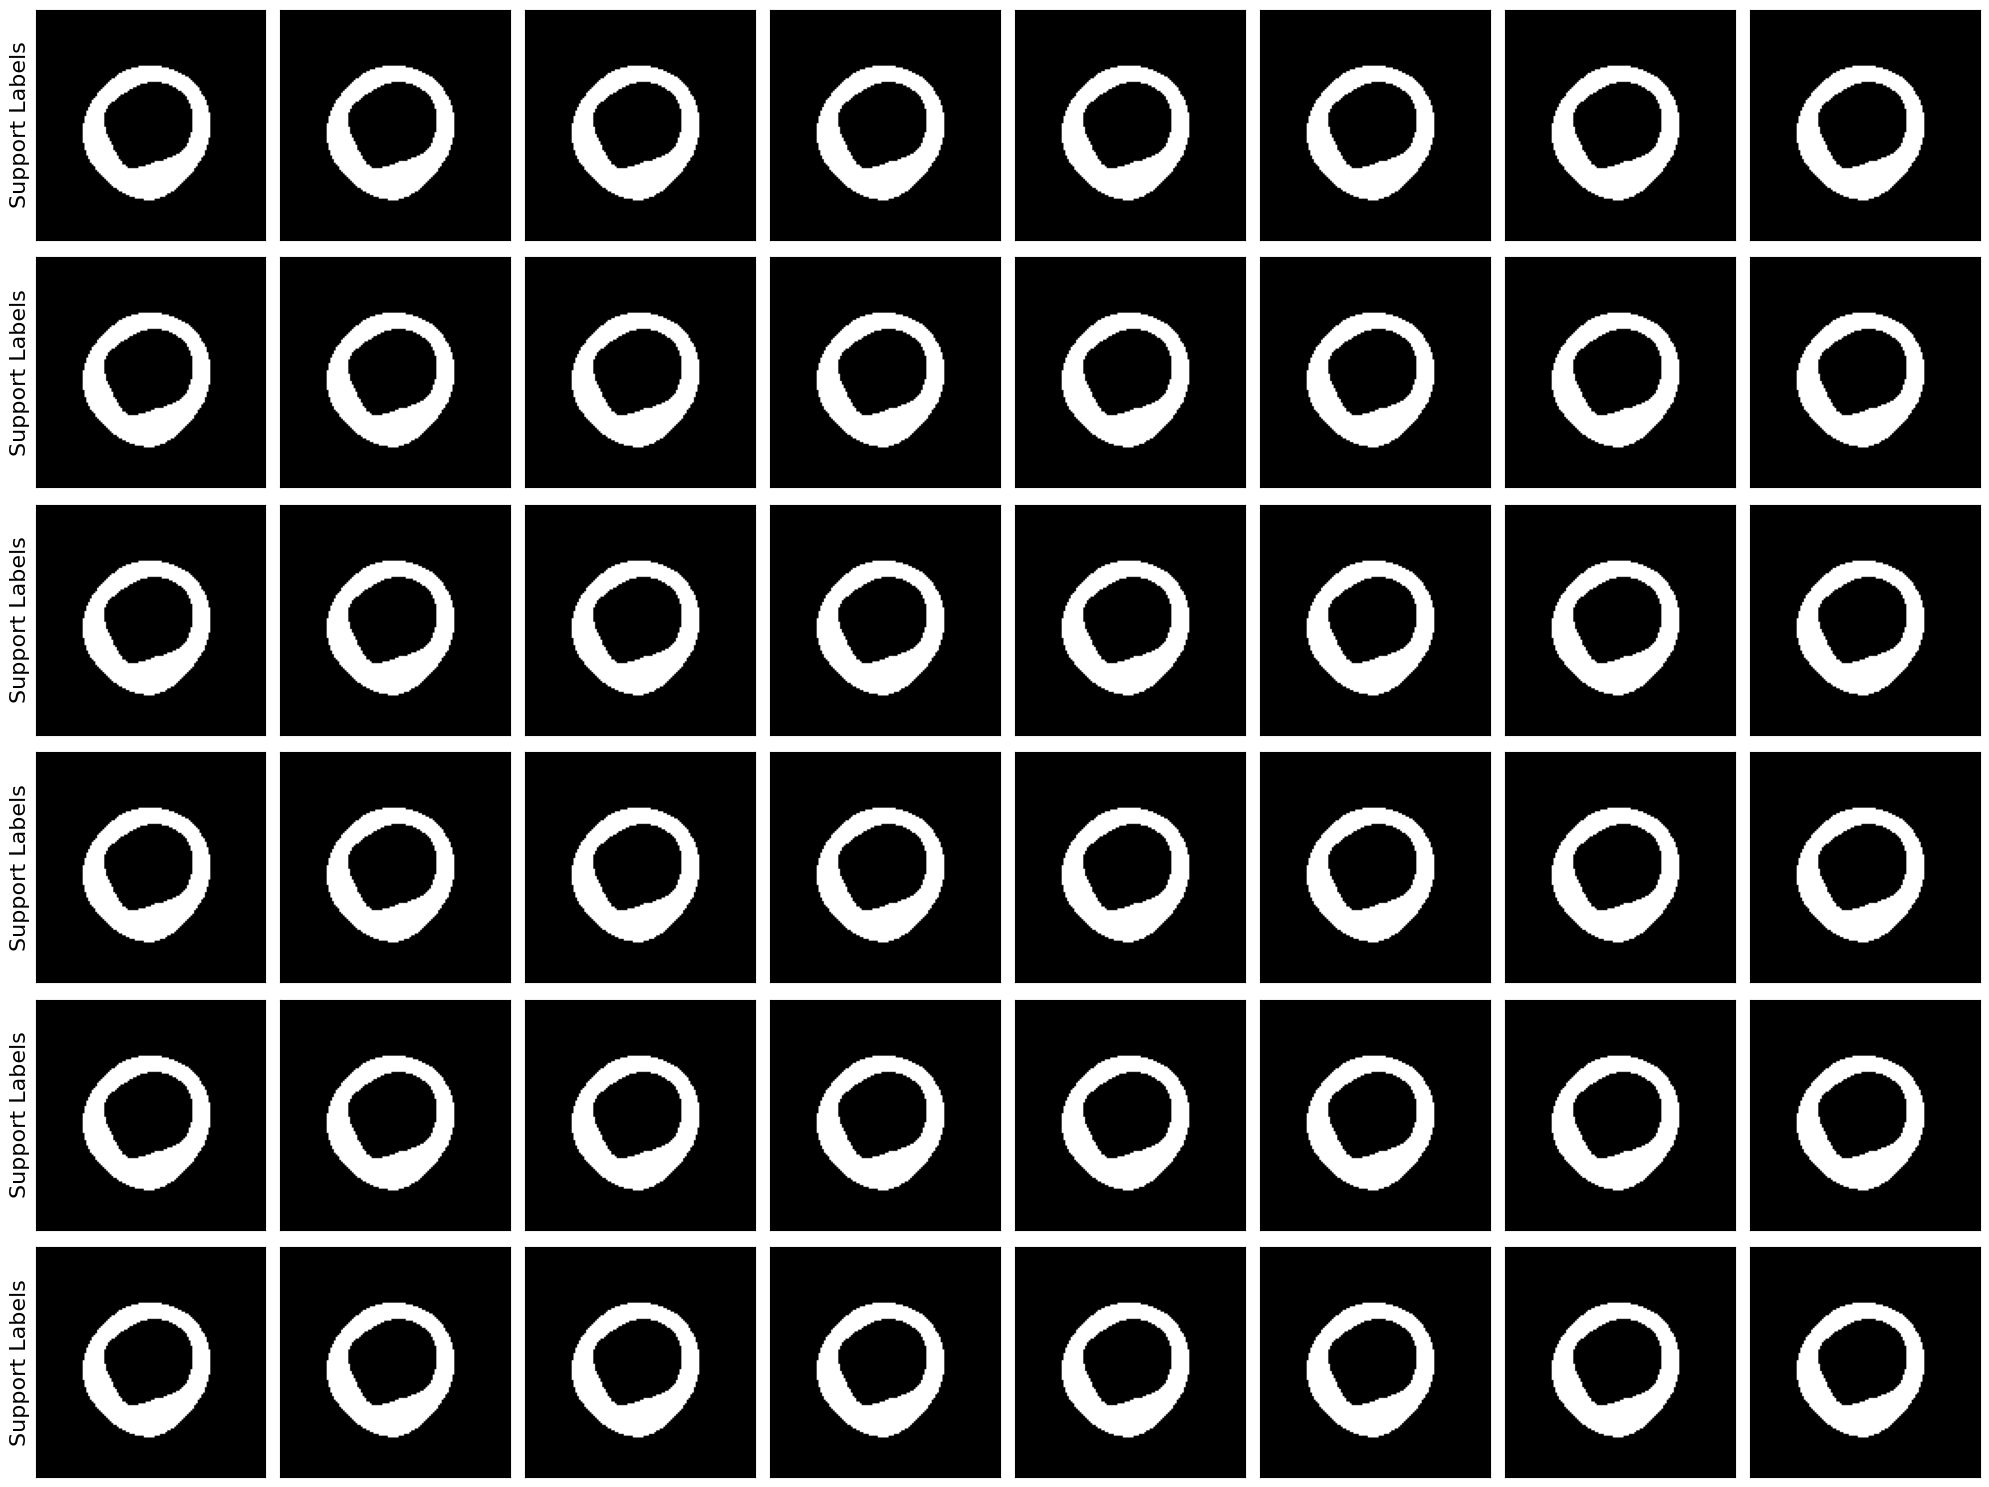

In [17]:
# Visualize support images
visualize_tensors({'Support Images': support_images})

# Visualize support labels
visualize_tensors({'Support Labels': support_labels})

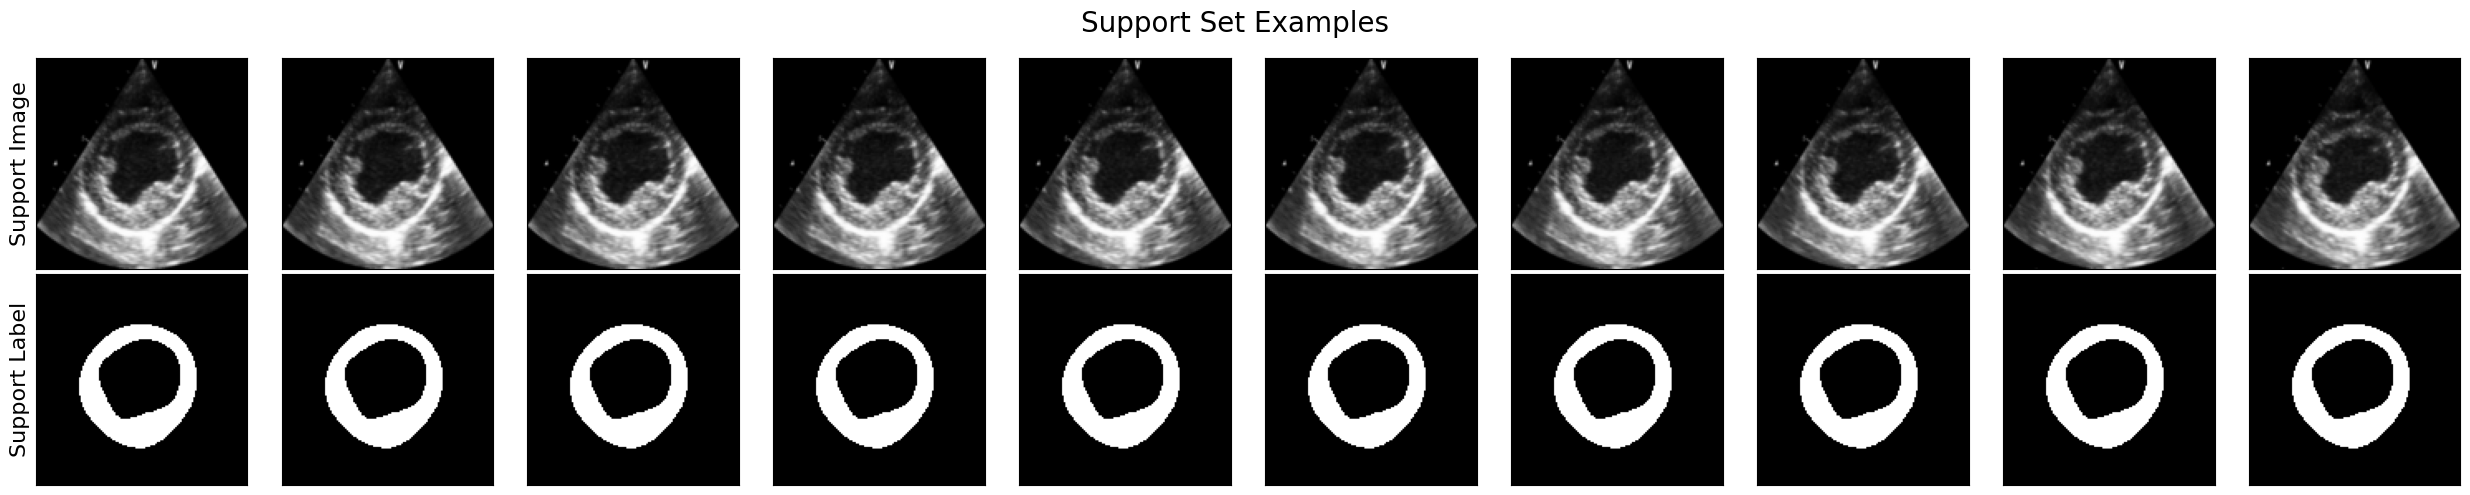

In [18]:
import math
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples', figsize=(20, 20))

In [19]:
print("Support Images Shape:", support_images.shape)
print("Support Labels Shape:", support_labels.shape)


Support Images Shape: torch.Size([48, 1, 128, 128])
Support Labels Shape: torch.Size([48, 1, 128, 128])


Let's perform inference on a test entry and visualize the prediction

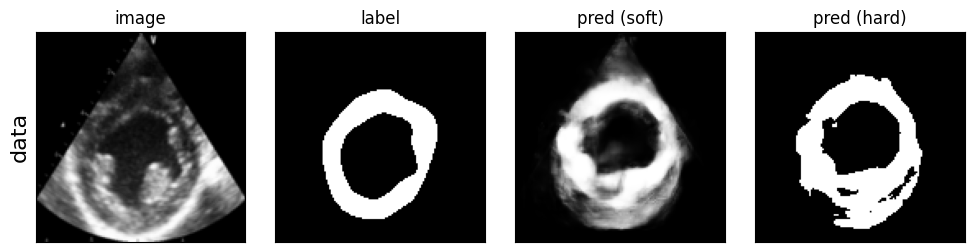

In [20]:

# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
#image = image.unsqueeze(0) 
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# # visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

### Inference Analysis


In [21]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


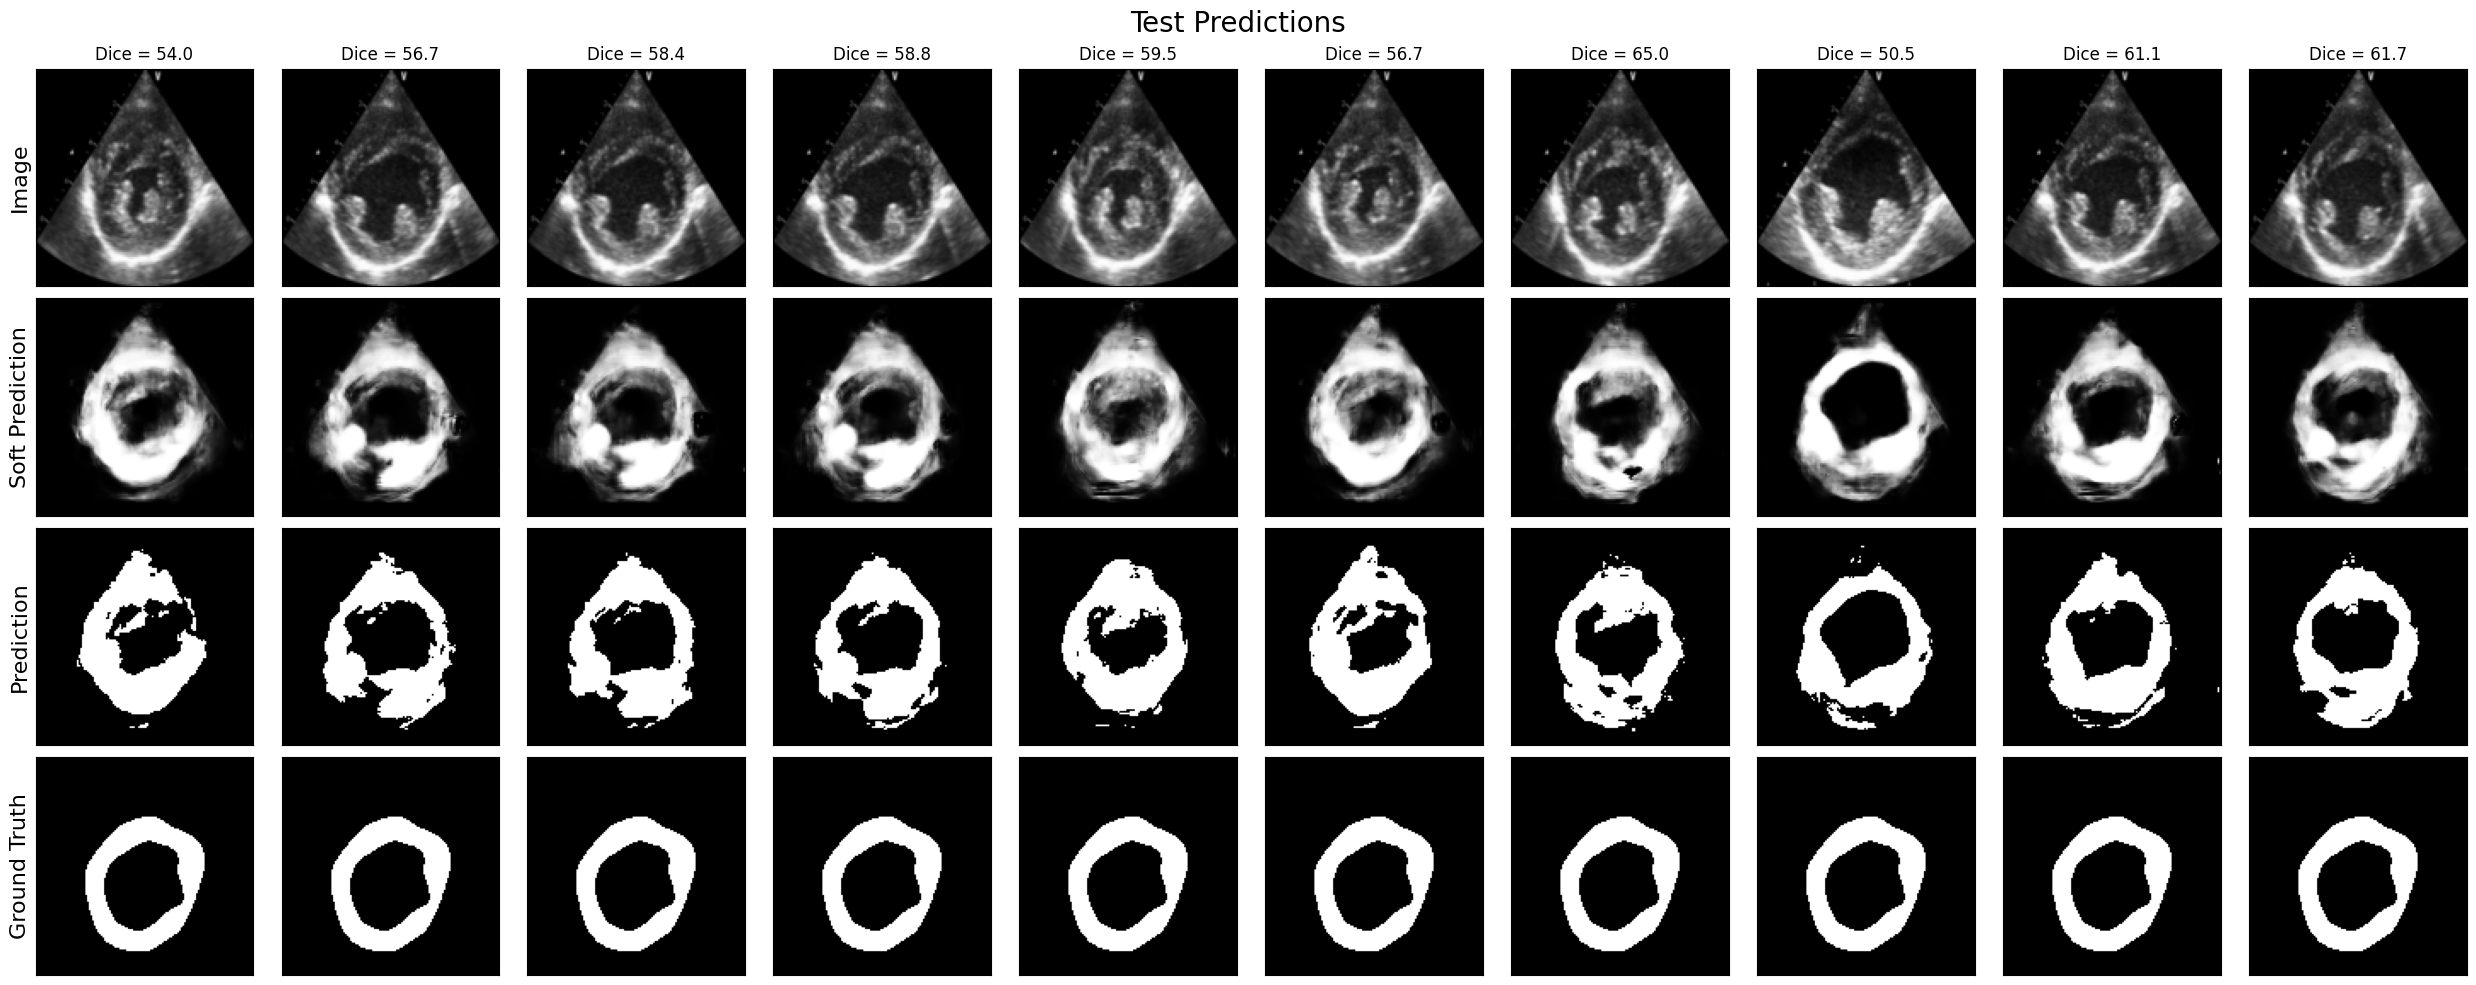

In [22]:
from collections import defaultdict
n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

##### Change support labels

In [23]:
n_support = 64

In [24]:
# extract nucleus support data
d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder)
d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

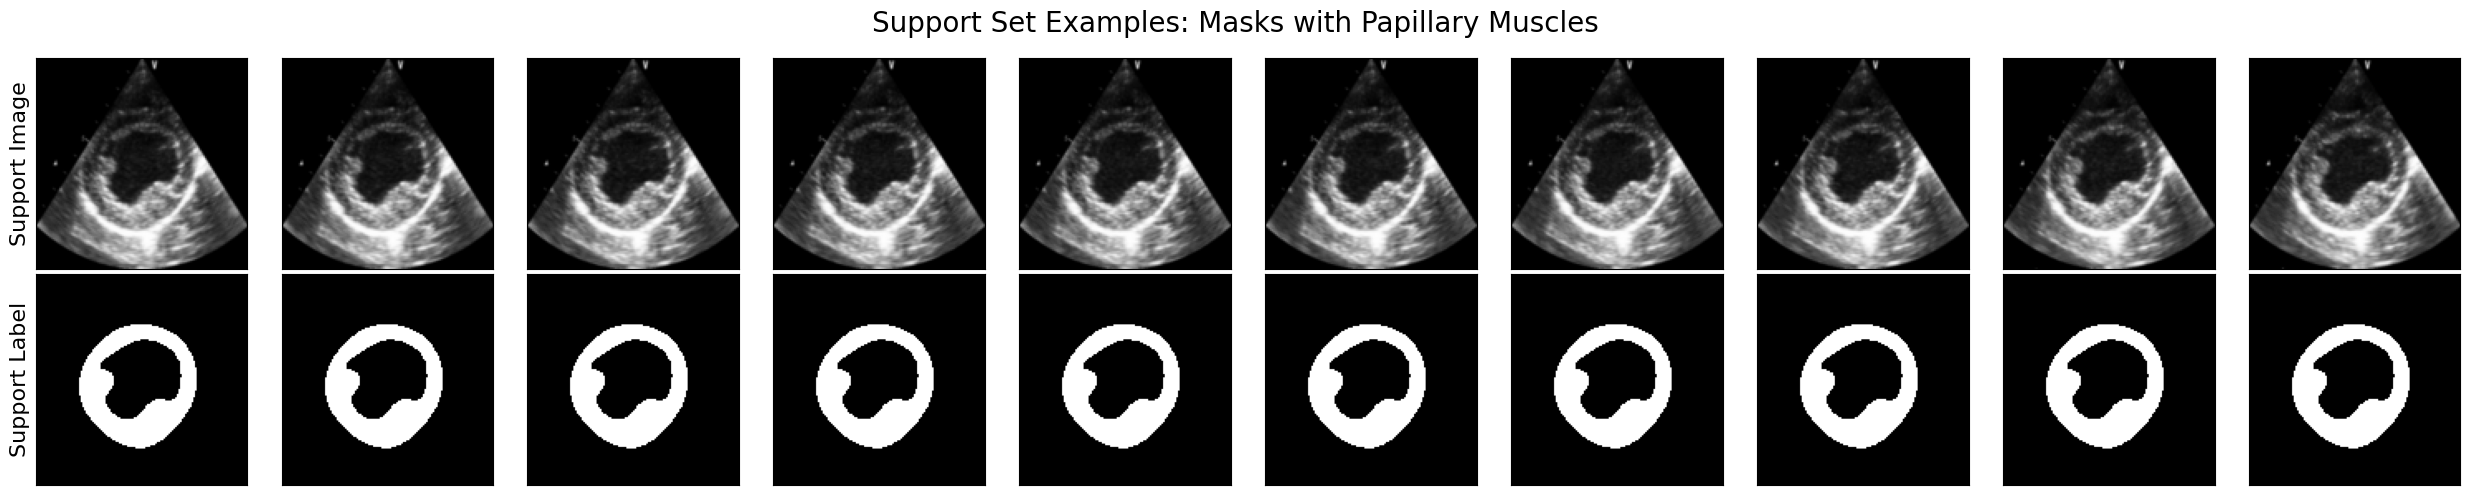

In [25]:
# visualize nucleus support data
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples: Masks with Papillary Muscles', figsize=(20, 20))

100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


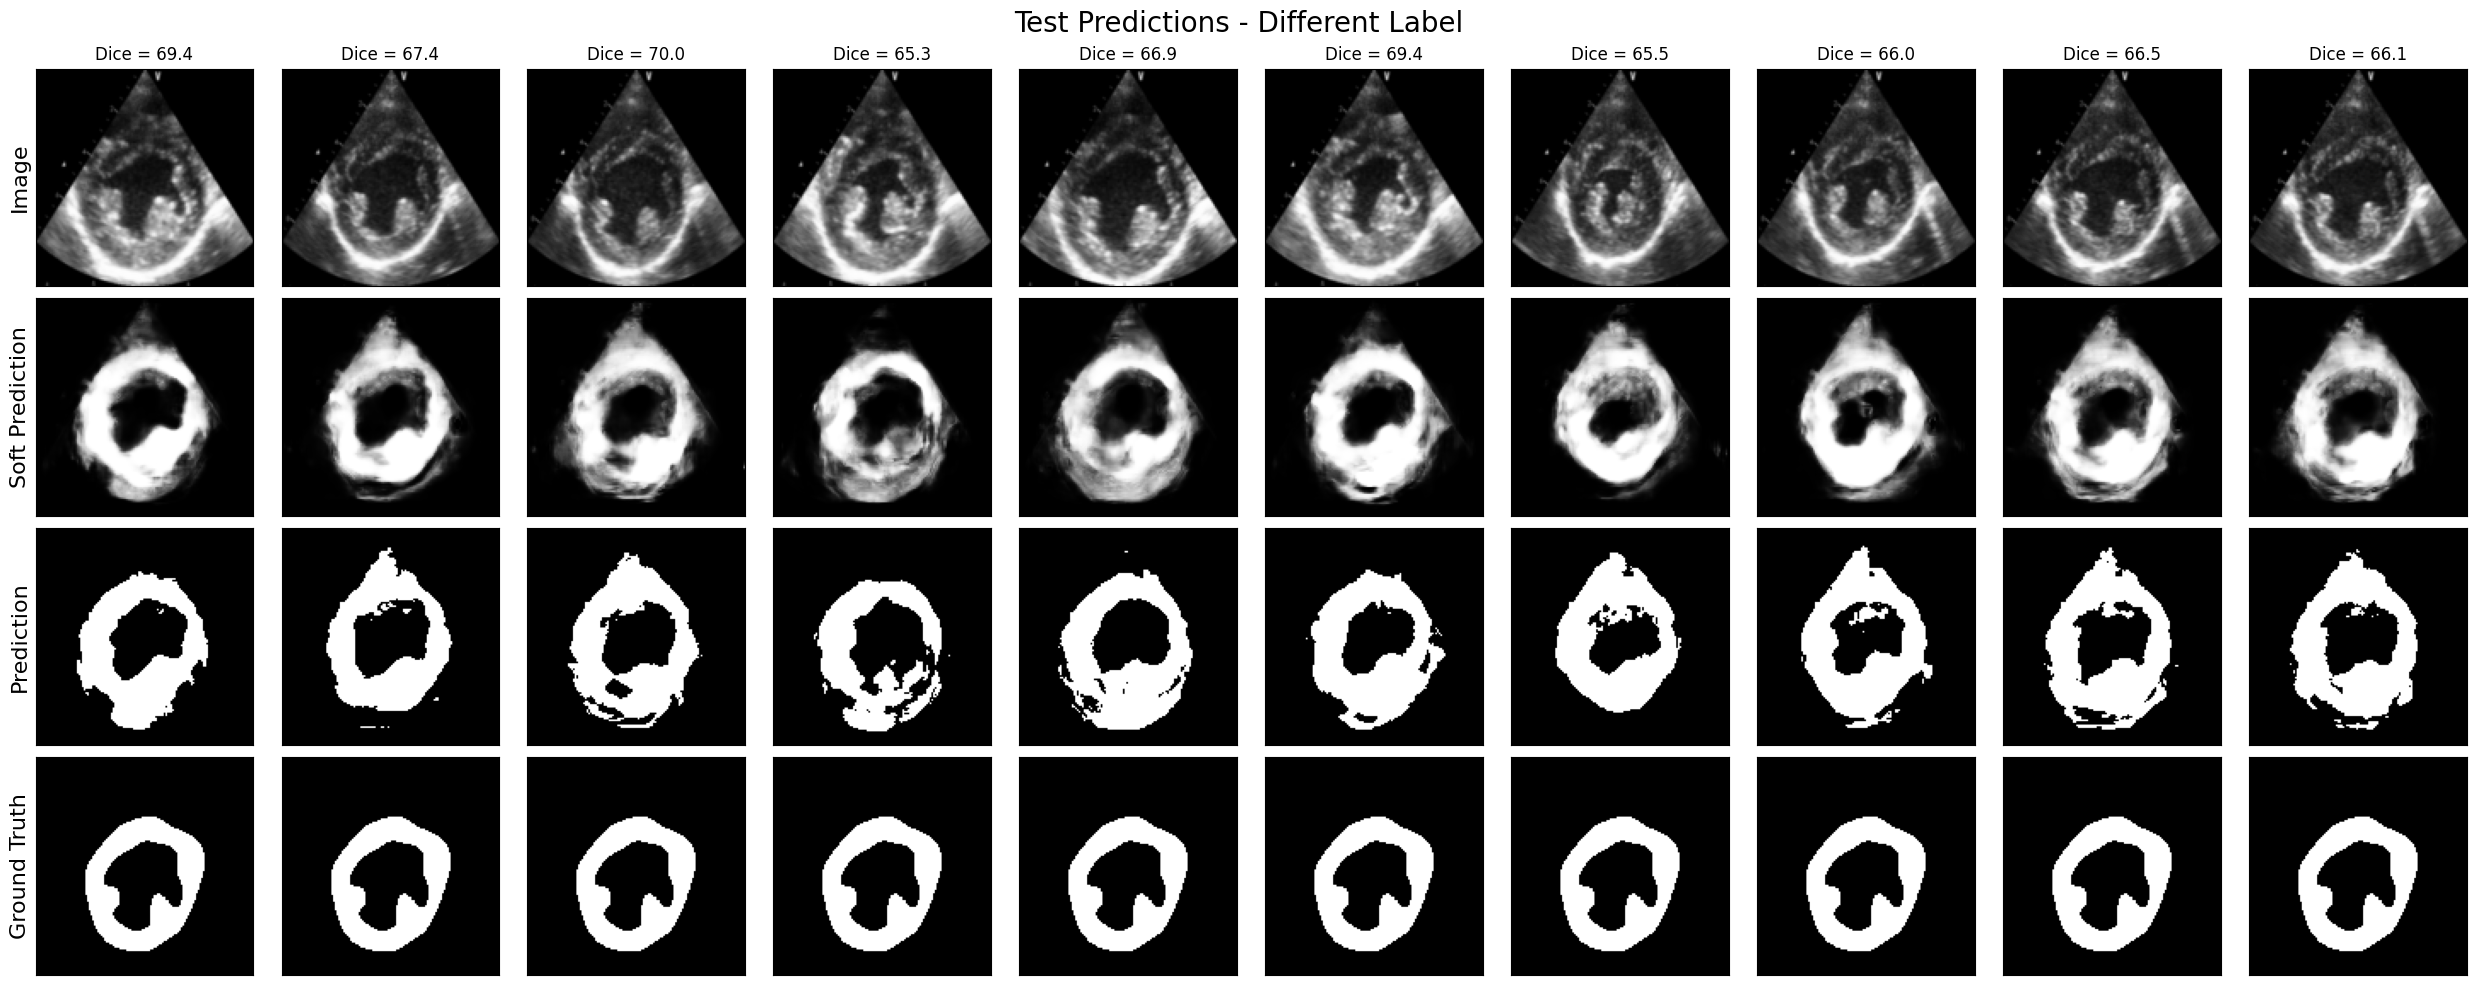

In [26]:
n_predictions = 10

results = defaultdict(list)

idxs = np.random.permutation(len(d_test))[:n_predictions]
for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Different Label', col_wrap=n_predictions)

In [27]:
##changing input not possible at the moment since we only have one dataset

### Effect of the Support Set Size

In [28]:

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)



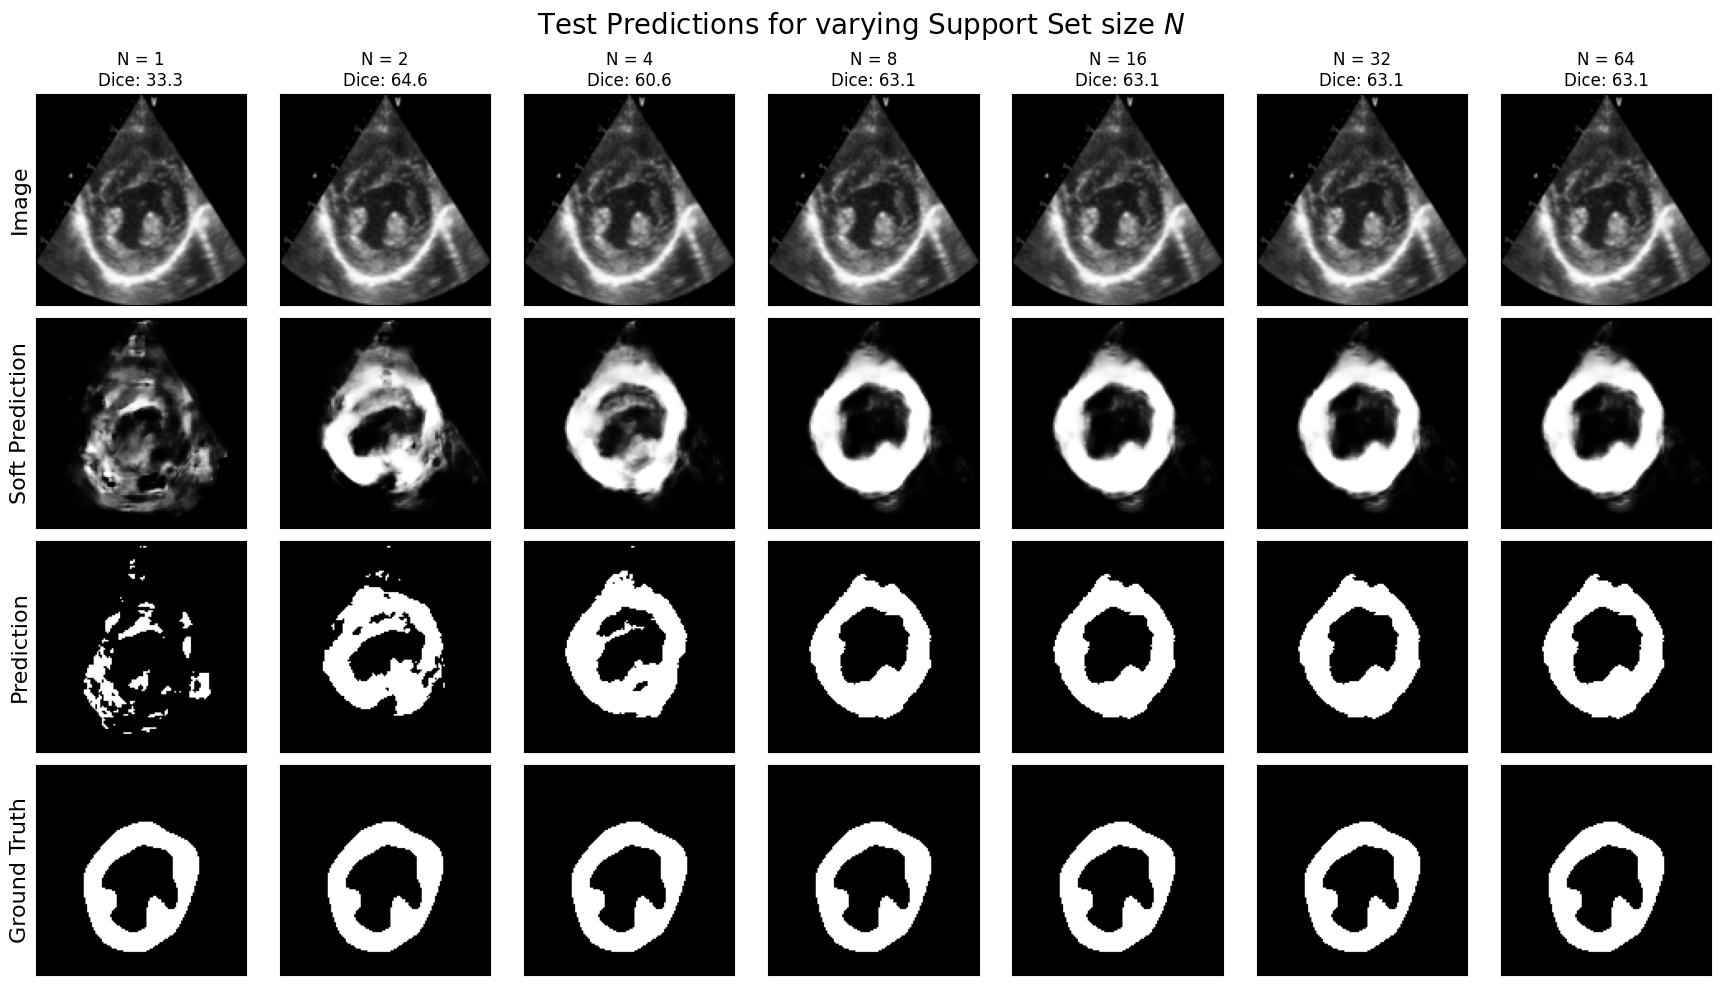

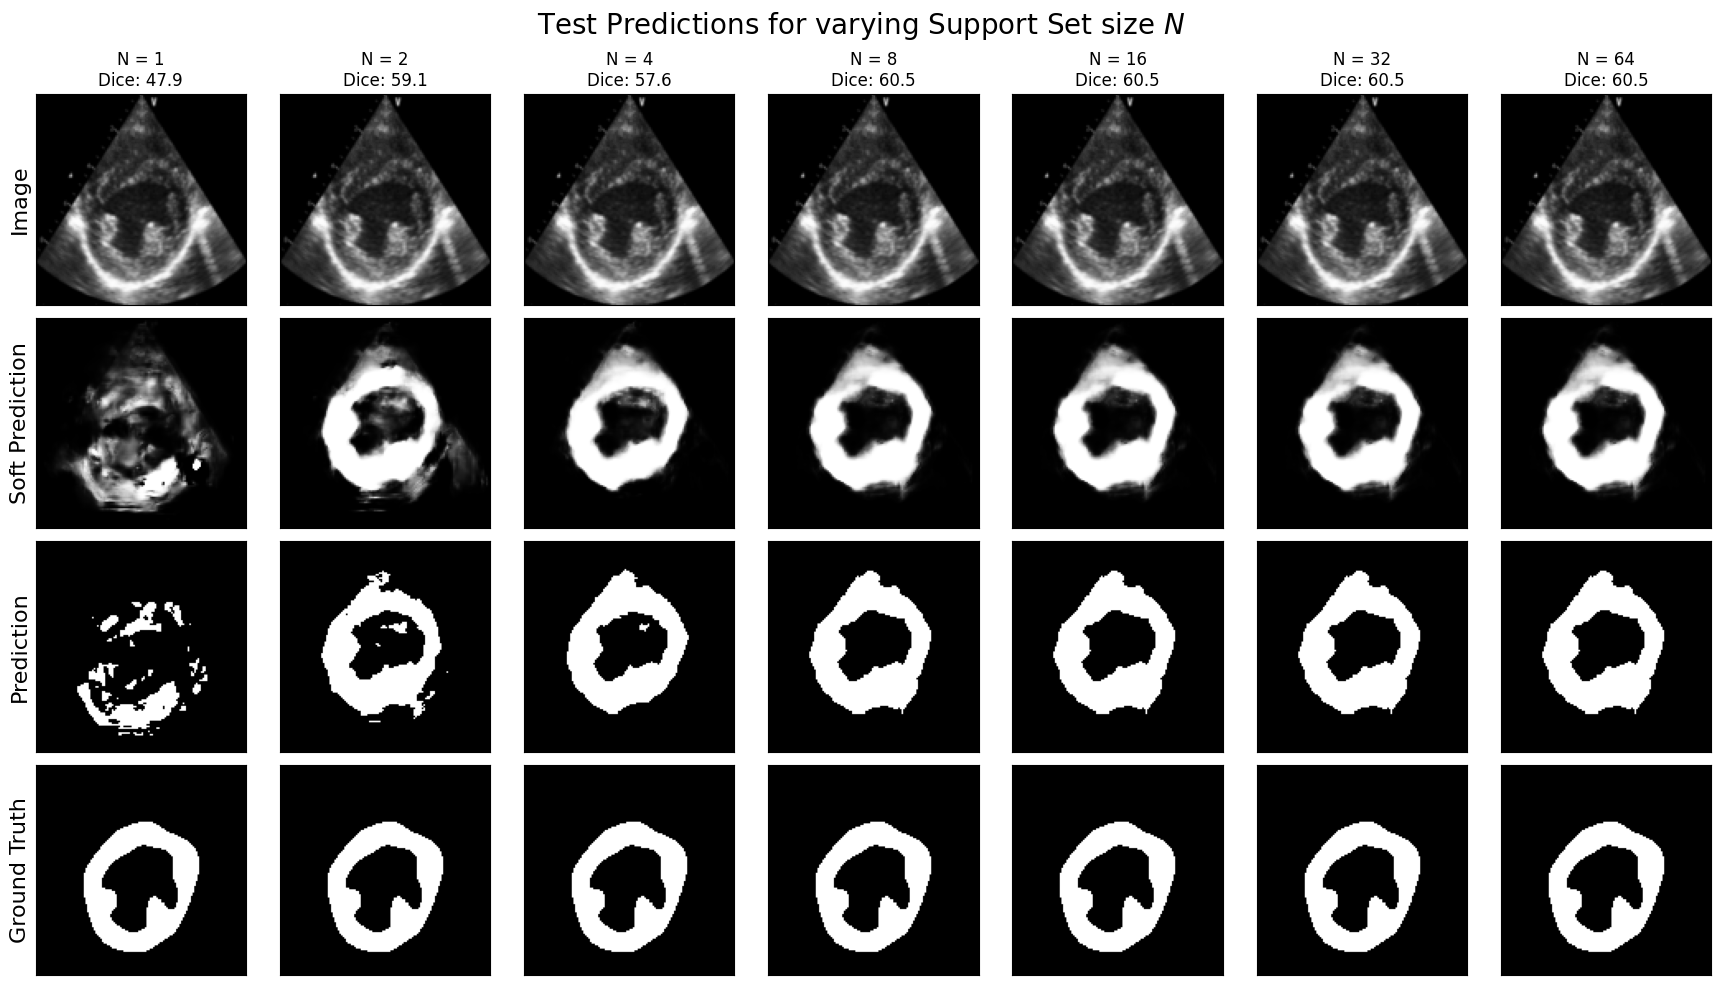

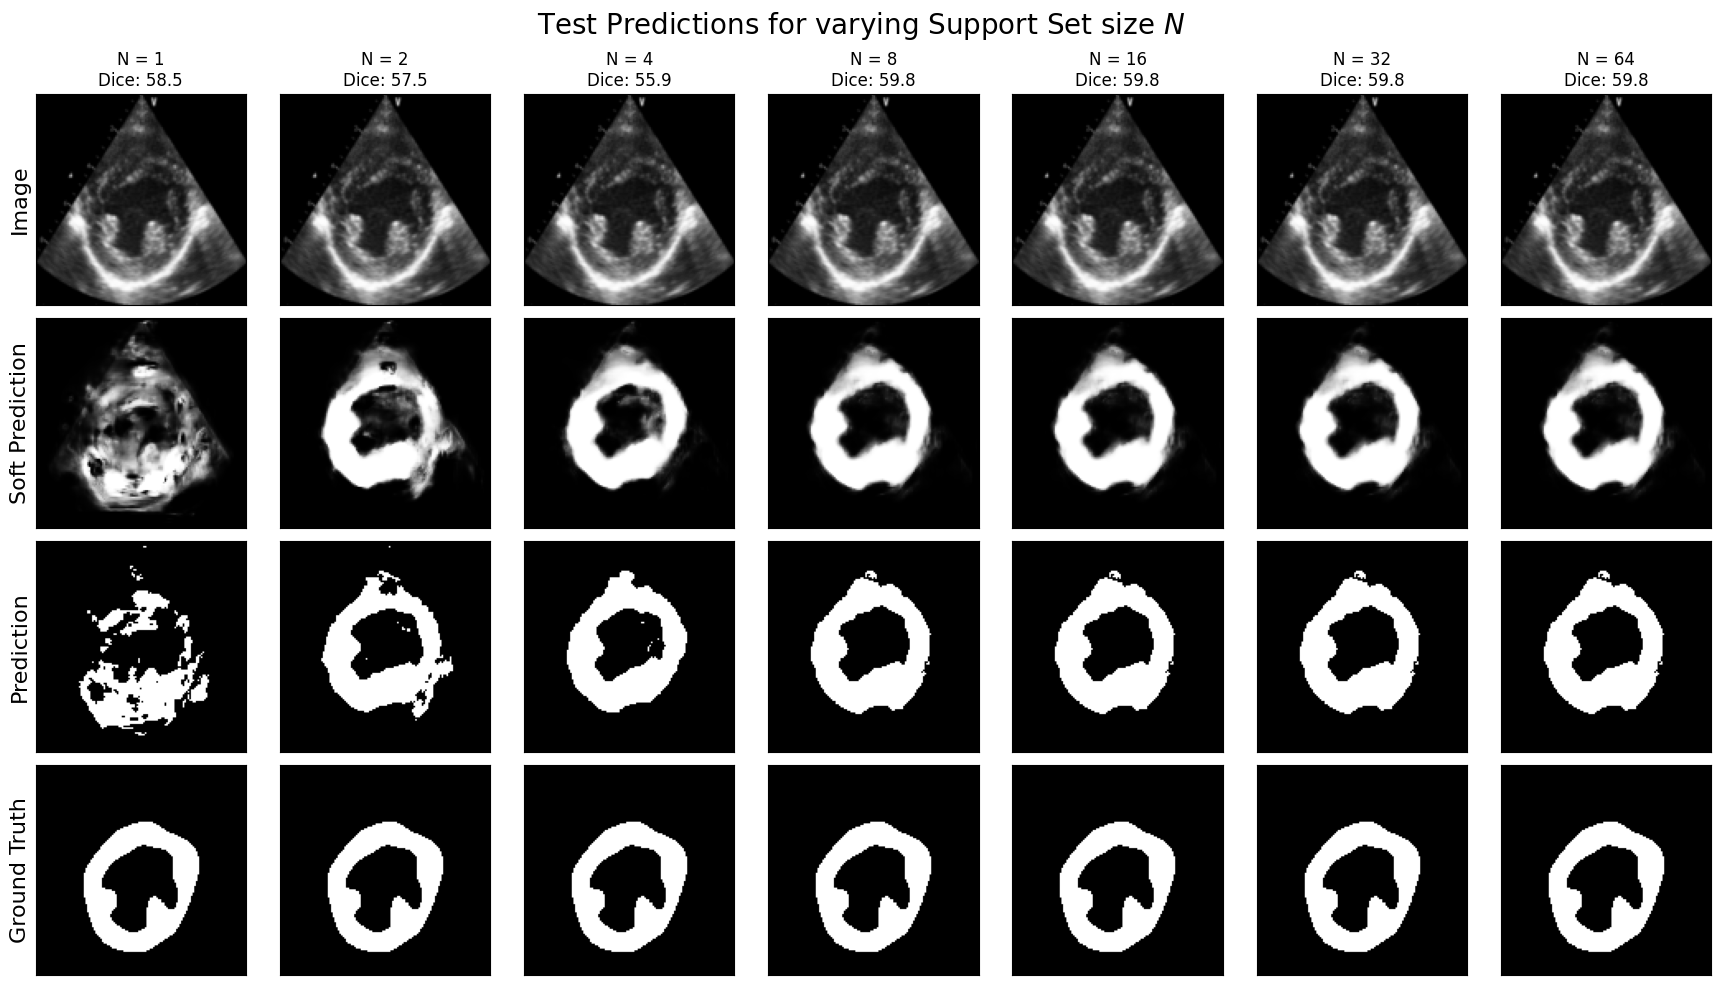

In [51]:
n_predictions = 3 #1446
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

## why certain pictures random 

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))
# Print the list of Dice scores for different support set sizes
# for N, dice_scores in zip(support_set_sizes, results_dict['Dice Score']):
#     print(f"Support Set Size: {N}, Dice Scores: {dice_scores}")


# Print the list of Dice scores for different support set sizes
# for N, dice_scores in results_dict.items():
#     average_dice_score = np.mean(dice_scores)
#     print(f"Support Set Size: {N}, Average Dice Score: {average_dice_score}")

# Print the list of Dice scores for different support set sizes


#### Average dice score per support set size

In [56]:
n_predictions = 3  # 1446
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

# Collect dice scores for different support set sizes
results_dict = defaultdict(list)

# why certain pictures random 
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        score = vals['score']
        results_dict[N].append(score)

# Print the list of average Dice scores for each support set
for N, dice_scores in results_dict.items():
    average_dice_score = np.mean(dice_scores)
    print(f"Support Set Size: {N}, Average Dice Score: {average_dice_score}")


Support Set Size: 1, Average Dice Score: 0.4401357074578603
Support Set Size: 2, Average Dice Score: 0.6410635511080424
Support Set Size: 4, Average Dice Score: 0.6358571648597717
Support Set Size: 8, Average Dice Score: 0.6487026214599609
Support Set Size: 16, Average Dice Score: 0.6487026214599609
Support Set Size: 32, Average Dice Score: 0.6487026214599609
Support Set Size: 64, Average Dice Score: 0.6487026214599609


In [60]:

# Import necessary libraries
from collections import defaultdict
import numpy as np

# Define variables
n_predictions = 3  # Number of test images to randomly select
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]  # Different support set sizes

# Dictionary to collect dice scores for different support set sizes
results_dict = defaultdict(list)

# Randomly select test images
idxs = np.random.permutation(len(d_test))[:n_predictions]

# Iterate over the selected test images
for i in idxs:
    # Iterate over different support set sizes
    for N in support_set_sizes:
        # Get the test image and its label
        image, label = d_test[i]
        # Perform inference and get the dice score
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        score = vals['score']
        # Collect the dice score for this support set size
        results_dict[N].append(score)

# Calculate the average Dice score across all support set sizes for each test image
average_dice_scores = []
for i in range(n_predictions):
    dice_scores_for_image = [results_dict[N][i] for N in support_set_sizes]
    average_dice_score_for_image = np.mean(dice_scores_for_image)
    average_dice_scores.append(average_dice_score_for_image)

# Print the average Dice score for each test image
for i, average_dice_score in enumerate(average_dice_scores, start=1):
    print(f"Average Dice Score for random Test Image {i}: {average_dice_score}")

    
    #randomly chosen images, so not like in the index of the original datasets

Average Dice Score for random Test Image 1: 0.5801634362765721
Average Dice Score for random Test Image 2: 0.6170178311211723
Average Dice Score for random Test Image 3: 0.6025488419192178


In [ ]:
##I propose giving an average on the three images as the baseline dice score as option one
#so, you make the average of the scores of n_predictions = 3 or try finding out with other numbers


#### Multi-label Predictions

In [30]:
# d_support = VentricleDataset(support_input_folder, label=None)
# d_test = VentricleDataset(test_input_folder, label=None)
# 
# n_support = 64
# 
# support_images, support_labels = zip(*itertools.islice(d_support, n_support))
# support_images = torch.stack(support_images).to(device)
# support_labels = torch.stack(support_labels).to(device)

### Ensembling Predictions

In [31]:
# helpful function to sample support data
def sample_support(seed):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels

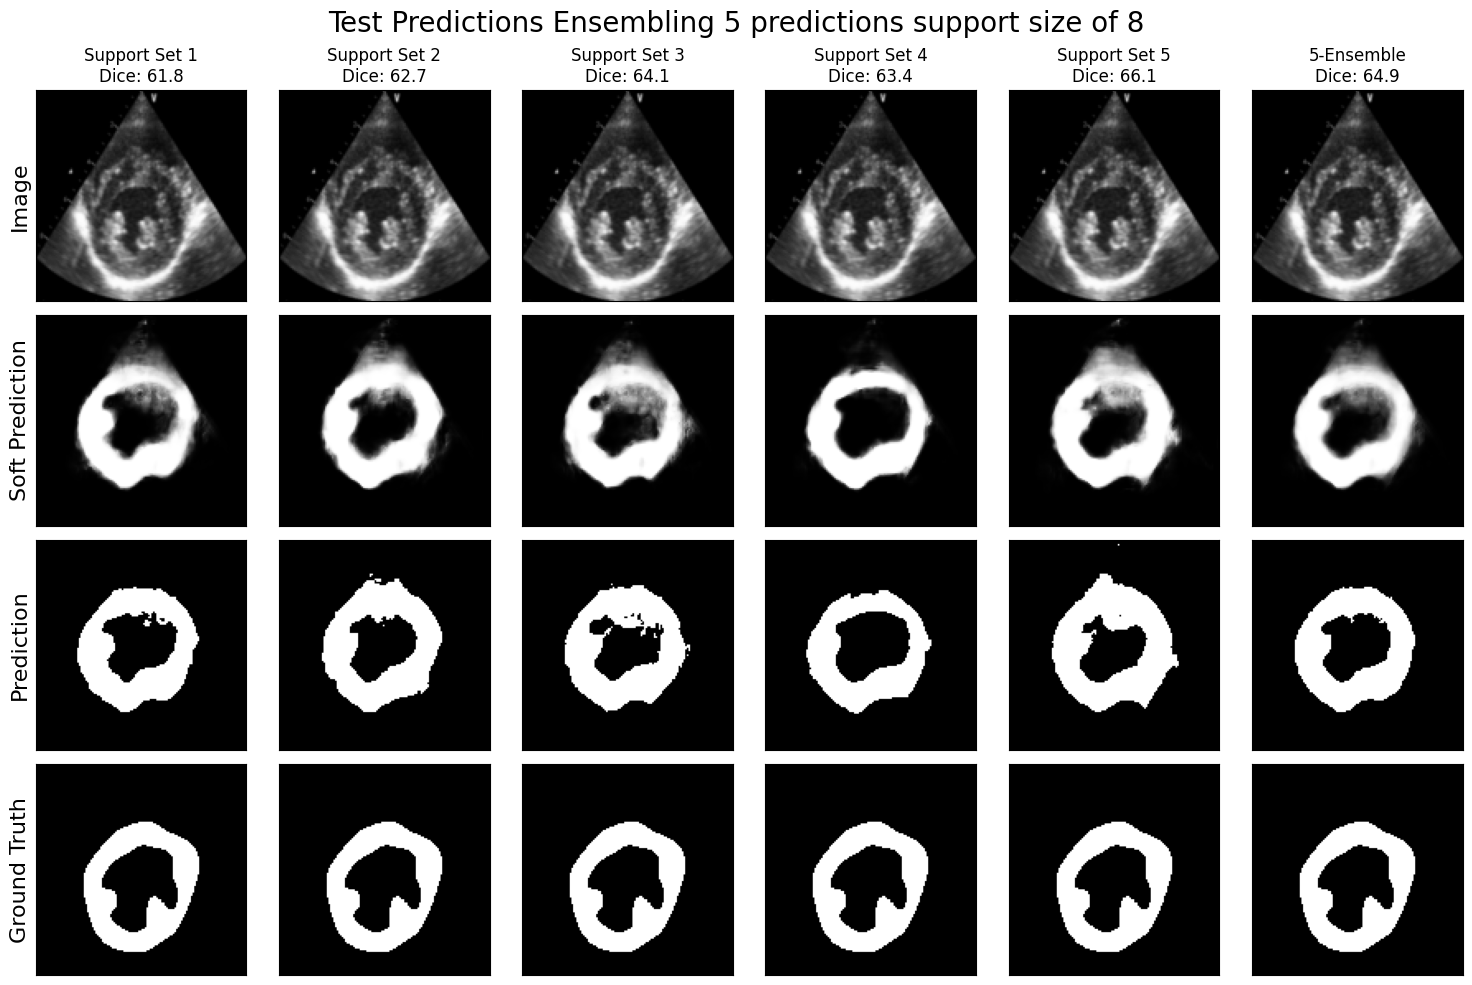

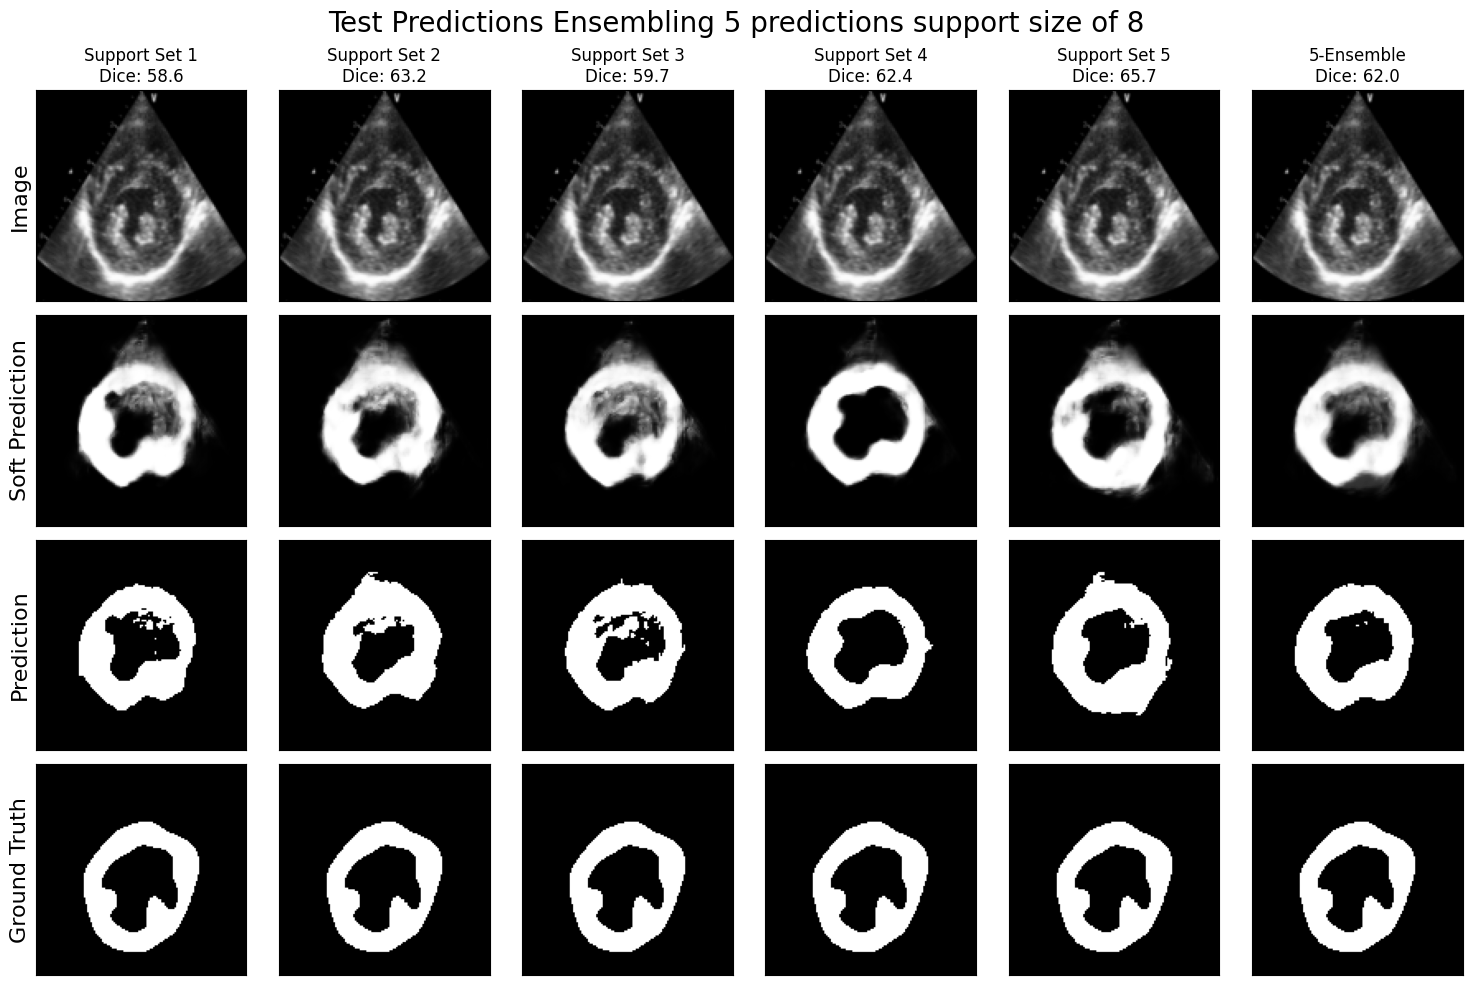

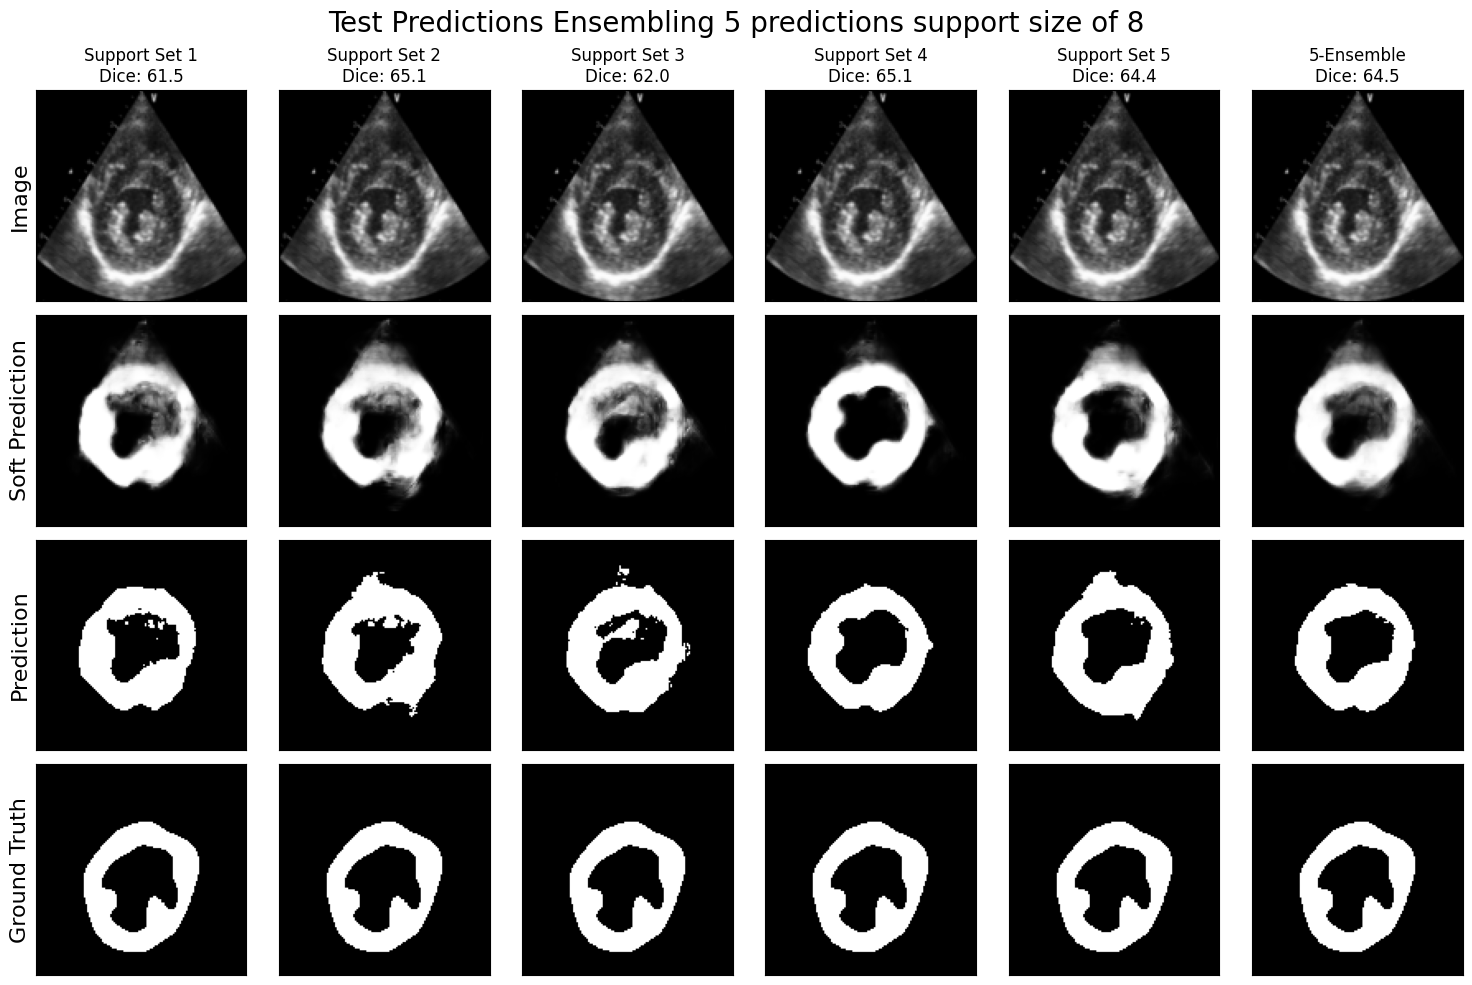

In [41]:
# get support data
# d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
# d_test = WBCDataset('JTSC', split='test', label='cytoplasm')
d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder)
d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)


# setup the number of predictions and ensembling
support_size = 8
n_predictions = 3
n_ensemble = 5

# get various support sets
idxs = np.random.permutation(len(d_test))[:n_predictions]
seeds = range(n_ensemble)
supports = {
    seed: sample_support(seed)
    for seed in range(n_ensemble)
}

# go through the number of experiments
for i in idxs:

    # go through the number of predictions we will ensemble
    results = defaultdict(list)
    for j in range(n_ensemble):
        # get support set and query
        support_images, support_labels = sample_support(j)
        image, label = d_test[i]

        # perform inference
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)

    results['Image'].append(image)
    ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
    results['Soft Prediction'].append(ensemble)
    results['Prediction'].append(ensemble.round())
    results['Ground Truth'].append(label)
    results['score'].append(dice_score(ensemble.round(), label.to(device)))

    scores = results.pop('score')
    col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]

    visualize_tensors(results,
                      col_names=col_names,
                      title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}',
                      col_wrap=n_ensemble+1)

In [ ]:
##option 2 would be doing same as option one but including ensembling 